## Importing Libraries      

In [60]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tqdm
import matplotlib.image as Image
import random


## Helper Functions

In [61]:
def imageToArray(image):
    img=Image.imread(image)
    img=img.reshape(-1,)
    return img

def arrayToImage(array,l,b,h):
    newimg=array.reshape(l,b,h)
    return newimg

# Modulo Inverse

def moduloInverse(a,m):
    for i in range(1,m):
        if (a*i)%m==1:
            return i
        
def isPrime(n):
    if n==2:
        return True
    if n%2==0:
        return False
    for i in range(3,int(math.sqrt(n))+1,2):
        if n%i==0:
            return False
    return True

# Lambda Generator
        
def lambdaGenerator(p1,q1,p2,q2,a,b,p):
    if(p1==p2 and q1==q2):
        l=((3*(p1**2)+a)*moduloInverse(2*q1,p))%p
    else:
        l=((q2-q1)*moduloInverse(p2-p1,p))%p
    return l

# Point Addition

def pointAddition(p1,q1,p2,q2,a,b,p):
    if(p1==0 and q1==0):
        return p2,q2
    if(p2==0 and q2==0):
        return p1,q1
    if((q1+q2)%p==0 and p1==p2):
        return 0,0
    l=lambdaGenerator(p1,q1,p2,q2,a,b,p)
    p3=(l**2-p1-p2)%p
    q3=(l*(p1-p3)-q1)%p
    return p3,q3

# Point Multiplication in log(n) time

def pointMultiplication(p1,q1,a,b,p,n):
    inip1=p1
    iniq1=q1
    while(n>0):
        if(n%2==1):
            p1,q1=pointAddition(p1,q1,inip1,iniq1,a,b,p)
        inip1,iniq1=pointAddition(inip1,iniq1,inip1,iniq1,a,b,p)
        n=n//2
    return p1,q1

# Elliptic Curve Generator

def primeNumberGenerator():
    primeslist=[]
    for i in range(200,400):
        if isPrime(i):
            primeslist.append(i)
    p=random.choice(primeslist)
    return p

# Computing Negative of a Point

def negative(p1,q1,p):
    return p1,-q1%p

# Finding Order of a Point

def findOrder(p1,q1,a,b,p,order):
    p2,q2=p1,q1
    for i in range(1,order):
        p2,q2=pointAddition(p2,q2,p1,q1,a,b,p)
        if(p2==0 and q2==0):
            return i+1
    return -1

# Generate all points on the curve

def findPoints(a,b,p):
    points=[]
    for i in range(p):
        for j in range(p):
            if((j**2)%p==((i**3+a*i+b)%p)):
                points.append((i,j))
    return points



## Elliptic Curve Generator

In [62]:
def curveGenerator():
    finalpoints=[]
    actualp=0
    actuala=0
    actualb=0
    gen=()
    while(True):
        p=primeNumberGenerator()
        a=random.randint(1,p-1)
        b=random.randint(1,p-1)
        while((4*(a**3)+27*(b**2))%p==0):
            a=random.randint(1,p-1)
            b=random.randint(1,p-1)
        points=findPoints(a,b,p)
        order=0
        for i in range(len(points)):
            if order<findOrder(points[i][0],points[i][1],a,b,p,len(points)+1):
                order=findOrder(points[i][0],points[i][1],a,b,p,len(points)+1)
                gen=points[i]
        if(order>=257):
            finalpoints=points
            actualp=p
            actuala=a
            actualb=b
            break
    return finalpoints,actualp,actuala,actualb,order,gen


In [63]:
print("Generating Curve")
finalpoints,p,a,b,order,gen=curveGenerator()
print("Curve Generated")
print("p =",p)
print("a =",a)
print("b =",b)
print("order =",order)
print("generator =",gen)

Generating Curve
Curve Generated
p = 311
a = 155
b = 204
order = 282
generator = (20, 150)


## Encryption and Decryption

In [64]:

def encrypt(point,p,a,b,order,gen,px,py,kplookup,kglookup):
    k=random.randint(1,order-1)
    kpx,kpy=kplookup[k]
    kgx,kgy=kglookup[k]
    ciphertext=[(kgx,kgy),pointAddition(point[0],point[1],kpx,kpy,a,b,p)]
    return ciphertext

def decrypt(ciphertext,p,a,b,order,nx):
    kgx,kgy=ciphertext[0]
    nkgx,nkgy=pointMultiplication(kgx,kgy,a,b,p,nx)
    nkgx,nkgy=negative(nkgx,nkgy,p)
    decrypted=pointAddition(ciphertext[1][0],ciphertext[1][1],nkgx,nkgy,a,b,p)    
    return decrypted


In [65]:
img1D= imageToArray("cat.jpeg")
img3D=Image.imread("cat.jpeg")
l,b,h=img3D.shape
print("l is ",l)
print("b is ",b)
print("h is ",h)
print("Image shape is ",img3D.shape)
print("Image array in 1D is ",img1D)
print("Image shape in 1D is ",img1D.shape)




l is  194
b is  259
h is  3
Image shape is  (194, 259, 3)
Image array in 1D is  [151 181 207 ...  52  47  44]
Image shape in 1D is  (150738,)


## MAIN PROGRAM

In [66]:
# Lookup tables for mapping points to pixels and vice versa

pixeltopoint={}
pointtopixel={}
pointtofieldindex={}

for i in range(0,len(finalpoints)):
    pointtofieldindex[finalpoints[i]]=i


for i in range (0,256):
    pixeltopoint[i]=finalpoints[i]
    pointtopixel[finalpoints[i]]=i

# Generating the private key

nx=random.randint(1,order-1)
print("The private key is ",nx)
px,py=pointMultiplication(gen[0],gen[1],a,b,p,nx)
print("The public key is ",px,py)

# Created a lookup table to store values of kG for all k from 0 to order-1

kglookup=[]
for i in range(0,order):
    kgx,kgy=pointMultiplication(gen[0],gen[1],a,b,p,i)
    kglookup.append((kgx,kgy))

# Created a lookup table to store values of kP for all k from 0 to order-1

kploopup=[]
for i in range(0,order):
    kpx,kpy=pointMultiplication(px,py,a,b,p,i)
    kploopup.append((kpx,kpy))

newimg1D=[]
for i in tqdm.tqdm(range (0, img1D.shape[0])):
    pixel=img1D[i]
    point=pixeltopoint[pixel]
    encryptedpoint=encrypt(point,p,a,b,order,gen,px,py,kploopup,kglookup)
    decryptedpoint=decrypt(encryptedpoint,p,a,b,order,nx)
    newpixel=pointtopixel[decryptedpoint]
    newimg1D.append(newpixel)

print("The decrypted image is",newimg1D)

    


The private key is  55
The public key is  16 101


100%|██████████| 150738/150738 [00:26<00:00, 5602.05it/s]

The decrypted image is [151, 181, 207, 150, 180, 206, 148, 178, 206, 146, 176, 204, 144, 174, 202, 142, 172, 200, 139, 170, 199, 138, 169, 198, 130, 163, 194, 131, 164, 195, 132, 165, 196, 133, 166, 197, 133, 168, 200, 134, 169, 201, 135, 170, 202, 136, 170, 207, 136, 169, 212, 135, 169, 215, 135, 169, 217, 130, 168, 215, 124, 164, 215, 117, 160, 211, 110, 156, 208, 104, 154, 207, 104, 156, 213, 102, 158, 215, 99, 160, 217, 96, 161, 219, 96, 162, 222, 95, 164, 223, 94, 164, 224, 95, 163, 224, 102, 166, 228, 104, 165, 228, 104, 165, 228, 104, 165, 228, 104, 165, 228, 104, 165, 228, 104, 165, 230, 104, 165, 230, 104, 165, 230, 104, 165, 230, 102, 166, 230, 102, 166, 230, 101, 165, 229, 101, 165, 229, 101, 165, 229, 100, 164, 228, 103, 169, 230, 104, 169, 227, 107, 169, 220, 107, 168, 225, 103, 167, 241, 100, 167, 245, 97, 170, 238, 103, 169, 229, 115, 161, 220, 132, 155, 189, 170, 166, 155, 166, 141, 101, 181, 138, 93, 178, 131, 75, 160, 115, 48, 144, 99, 34, 114, 60, 14, 112, 54, 16, 10

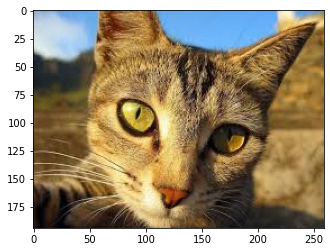

In [67]:
# change newimg1D to np array

newimg1D=np.array(newimg1D)
newimg3D=arrayToImage(newimg1D,l,b,h)
plt.imshow(newimg3D)